In [2]:
import os
from zipfile import ZipFile
from pathlib import Path
import requests

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["font.family"] = "DejaVu Sans"

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [3]:
def load_har_dataset(url, extract_path: Path, filename: str, overwrite=False):
    # check if existed already
    filepath = extract_path / filename
    if filepath.exists() and not overwrite:
        print("The dataset is already in place.")
        return

    print("Downloading the dataset from:  ", url)
    response = requests.get(url)

    with open(filepath, 'wb') as f:
        f.write(response.content)

    with ZipFile(filepath, 'r') as zipObj:
        # Extract all the contents of zip file in current directory
        zipObj.extractall(extract_path)

In [7]:
FILE_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
FILE_NAME = "UCI HAR Dataset.zip"
DATA_PATH = Path("C:\\Users\\mateu\\mlcourse.AI\\Topic07\\data")

load_har_dataset(url=FILE_URL, extract_path=DATA_PATH, filename=FILE_NAME)

PATH_TO_SAMSUNG_DATA = DATA_PATH / FILE_NAME.strip('.zip')

In [8]:
X_train = np.loadtxt(PATH_TO_SAMSUNG_DATA / "train" / "X_train.txt")
y_train = np.loadtxt(PATH_TO_SAMSUNG_DATA / "train" / "y_train.txt").astype(int)

X_test = np.loadtxt(PATH_TO_SAMSUNG_DATA / "test" / "X_test.txt")
y_test = np.loadtxt(PATH_TO_SAMSUNG_DATA / "test" / "y_test.txt").astype(int)

In [9]:
# Checking dimensions
assert X_train.shape == (7352, 561) and y_train.shape == (7352,)
assert X_test.shape == (2947, 561) and y_test.shape == (2947,)

In [12]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

In [13]:
n_classes = np.unique(y).size
np.unique(y).size

6

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X=X)

In [16]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

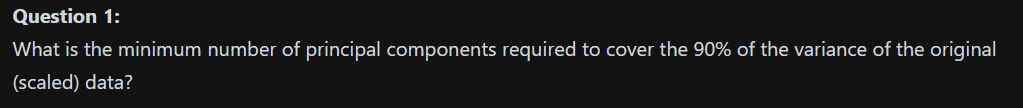

In [19]:
X_pca.shape

(10299, 65)

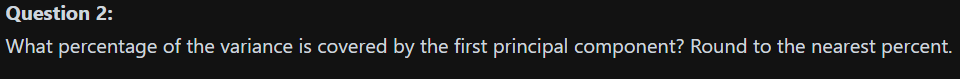

In [25]:
np.sum(pca.explained_variance_ratio_[0] * 100)

50.73822103501332

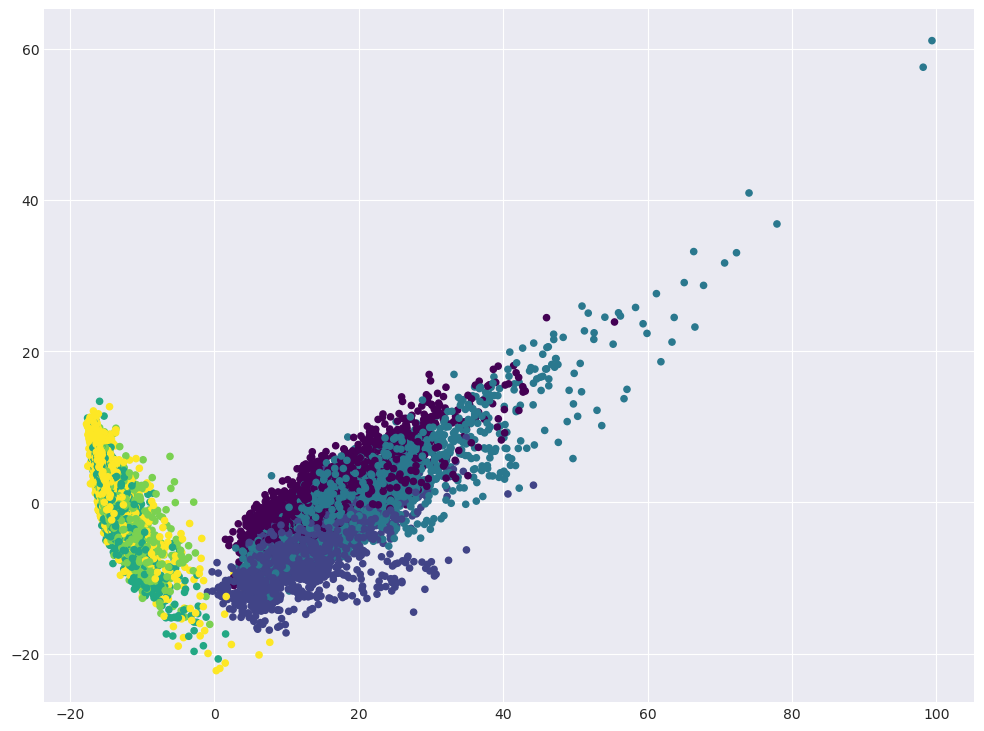

In [31]:
# Your code here
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap="viridis");

In [32]:
# Your code here
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

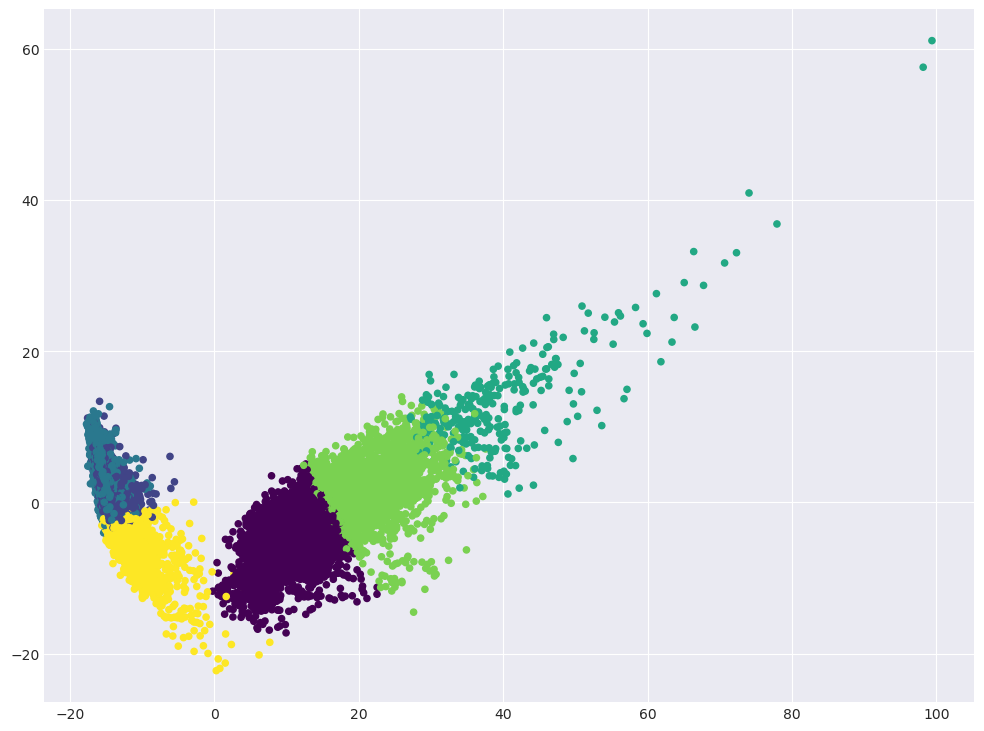

In [33]:
plt.scatter(X_pca[:,0],X_pca[:,1] , c=cluster_labels, s=20, cmap='viridis');

In [34]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['walking', 'going up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,903,0,0,78,741,0,1722
going up the stairs,1241,0,0,5,296,2,1544
going down the stairs,320,0,0,196,890,0,1406
sitting,1,1235,91,0,0,450,1777
standing,0,1344,0,0,0,562,1906
laying,5,52,1558,0,0,329,1944
all,2470,2631,1649,279,1927,1343,10299


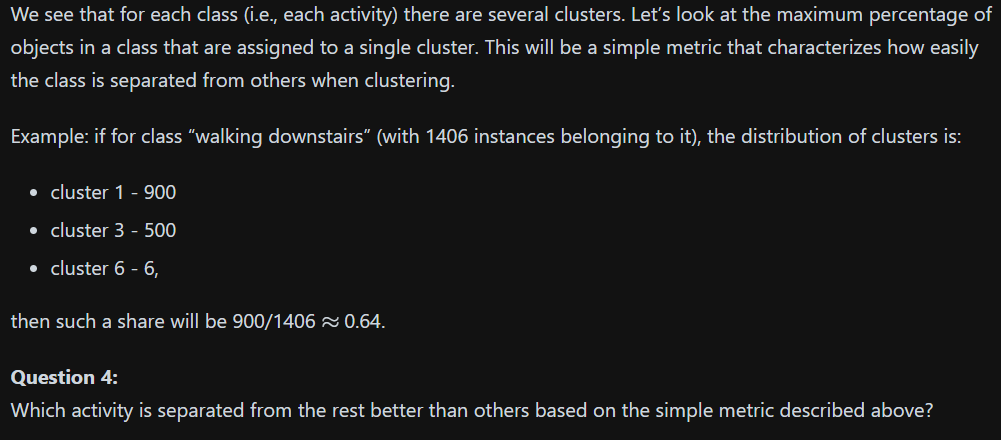

In [97]:
all = tab.loc[:,"all"]


for idx in range(tab.index.shape[0]):
    vals = (tab.iloc[idx,:-1]/tab.iloc[idx,-1])
    best_cluster_idx = vals.argmax()
    print(f"{tab.index[idx]}, best cluster: {tab.columns[best_cluster_idx]}, perc: {max(vals)}")
        


walking, best cluster: cluster1, perc: 0.524390243902439
going up the stairs, best cluster: cluster1, perc: 0.8037564766839378
going down the stairs, best cluster: cluster5, perc: 0.6330014224751067
sitting, best cluster: cluster2, perc: 0.694991558806978
standing, best cluster: cluster2, perc: 0.7051416579223505
laying, best cluster: cluster3, perc: 0.801440329218107
all, best cluster: cluster2, perc: 0.2554616953102243


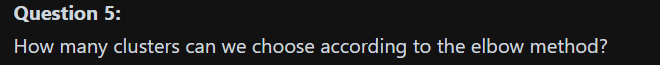

C:\Users\mateu\AppData\Local\Temp\ipykernel_28776\2881929459.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

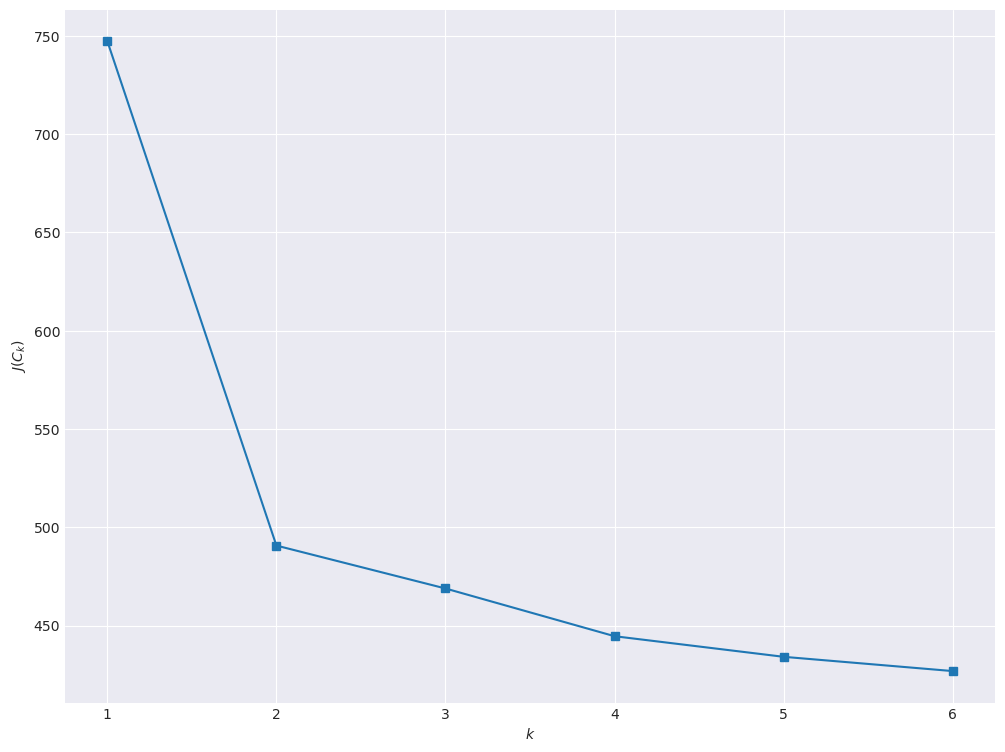

In [101]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init='auto').fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, n_classes+1), inertia, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$");

In [104]:
d = {}
for k in range(2, 6):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

d

{2: 0.08507882886566531,
 3: 1.1119423280777432,
 4: 0.431510664965226,
 5: 0.6928773434939944}

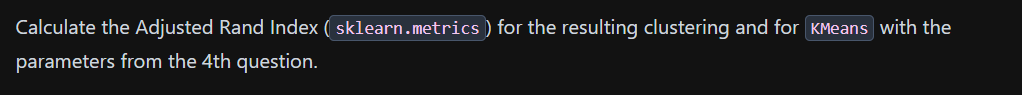

In [105]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)


print("KMeans: ARI =", metrics.adjusted_rand_score(y, cluster_labels))
print("Agglomerative CLustering: ARI =", metrics.adjusted_rand_score(y, ag.labels_))

KMeans: ARI = 0.4198070012602345
Agglomerative CLustering: ARI = 0.49362763373004886


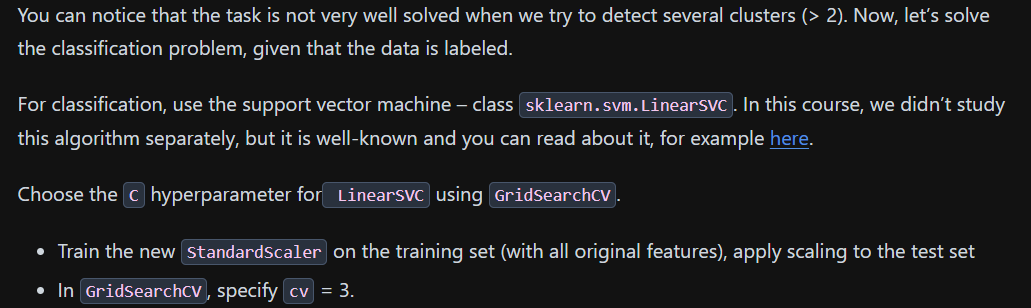

In [110]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

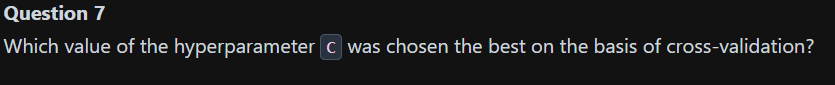

In [112]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {"C": [0.001, 0.01, 0.1, 1, 10]}

best_svc = GridSearchCV(svc, svc_params, n_jobs=4, cv=3, verbose=1)
best_svc.fit(X_train_scaled, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\mateu\anaconda3\envs\test2\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=3, estimator=LinearSVC(random_state=17), n_jobs=4,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, verbose=1)

In [113]:
best_svc.best_params_, best_svc.best_score_

({'C': 0.1}, 0.9382506099134881)

In [114]:
y_predicted = best_svc.predict(X_test_scaled)

In [115]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['walking', 'climbing up the stairs',
                'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['walking', 'climbing up the stairs',
                'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab

,walking,climbing up the stairs,going down the stairs,sitting,standing,laying,all
walking,494,2,0,0,0,0,496
climbing up the stairs,12,459,0,0,0,0,471
going down the stairs,2,3,414,1,0,0,420
sitting,0,4,0,426,61,0,491
standing,0,0,0,15,517,0,532
laying,0,0,0,0,11,526,537
all,508,468,414,442,589,526,2947


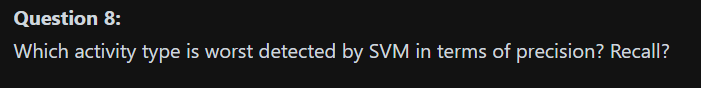

In [121]:

classes = tab.index[:-1]

recall = {}
precision = {}

for cls in classes:
    TP = tab.loc[cls, cls]
    FN = tab.loc[cls, 'all'] - TP
    FP = tab.loc['all', cls] - TP

    recall[cls] = TP / (TP + FN) if (TP + FN) > 0 else 0
    precision[cls] = TP / (TP + FP) if (TP + FP) > 0 else 0

# Wyniki
print("Recall:", recall)
print("Precision:", precision)


Recall: {'walking': 0.9959677419354839, 'climbing up the stairs': 0.9745222929936306, 'going down the stairs': 0.9857142857142858, 'sitting': 0.8676171079429735, 'standing': 0.9718045112781954, 'laying': 0.9795158286778398}
Precision: {'walking': 0.9724409448818898, 'climbing up the stairs': 0.9807692307692307, 'going down the stairs': 1.0, 'sitting': 0.9638009049773756, 'standing': 0.8777589134125636, 'laying': 1.0}


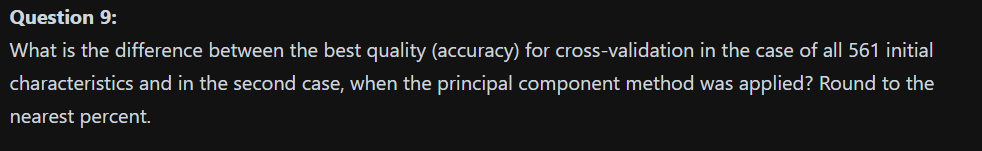

In [122]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [123]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {"C": [0.001, 0.01, 0.1, 1, 10]}

In [127]:
%%time
best_svc_pca = GridSearchCV(svc, svc_params, n_jobs=4, cv=3, verbose=1)
best_svc_pca.fit(X_train_pca, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: total: 1.14 s
Wall time: 5.25 s


c:\Users\mateu\anaconda3\envs\test2\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=3, estimator=LinearSVC(random_state=17), n_jobs=4,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, verbose=1)

In [128]:
best_svc_pca.best_params_, best_svc_pca.best_score_

({'C': 1}, 0.8998943094169531)

In [129]:
round(100 * (best_svc_pca.best_score_ - best_svc.best_score_))

-4